## NLP Tutorial: Text Classification Using Spacy Word Embeddings

### Problem Statement
- Fake news refers to misinformation or disinformation in the country which is spread through word of mouth and more recently through digital communication such as What's app messages, social media posts, etc.

- Fake news spreads faster than real news and creates problems and fear among groups and in society.

- We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is Real or Fake Message.

- We will use glove embeddings from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.

### Dataset
Credits: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

- This data consists of two columns. - Text - label

- Text is the statements or messages regarding a particular event/situation.

- label feature tells whether the given text is Fake or Real.

- As there are only 2 classes, this problem comes under the **Binary Classification**.


### SpaCY
- spaCY is an open source python library used for **Natural Language Processing** projects;
- it has some useful capabilities such as **word tokenization, stemming, stop word removal, Part Of speech tagging, named entity recognitin(NER)**;
- if you use the large model, it comes with vectors for various words;

In [1]:
import sys

# Replace 'path_to_spacy' with the actual path to spaCy
path_to_spacy = r'C:\Users\Motlatsi Moea\AppData\Local\Programs\Python\Python311\Lib\site-packages'

# Add the path to sys.path if it's not already there
if path_to_spacy not in sys.path:
    sys.path.append(path_to_spacy)

### Using large model in spacy
- using the large model gives you a pipeline and has vectors, whereas the small model has no vectors

In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [11]:
import pandas as pd

df = pd.read_csv("Fake_Real_Data.csv")
print(df.shape)
df.head(5)

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [12]:
#check the distribution of labels 
df['label'].value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

In [22]:
df['Text'][0]

"   Trump Surrogate BRUTALLY Stabs : ' pathetic ' ( video ) s look republican presidential candidate Donald Trump lose support rank . know thing get bad surrogate start turn , exactly happen Fox News Newt Gingrich call Trump    pathetic . Gingrich know Trump need focus Hillary Clinton remotely want chance defeat . , Trump hurt feeling Republicans don t support sexual assault woman turn , include House Speaker Paul Ryan ( R - WI ) . , Trump lash party . Gingrich say Fox News : look , , let Trump , admire ve try help . s big Trump little Trump . little Trump frankly pathetic . mean , s mad get phone ? Trump s refer fact Paul Ryan didn t congratulate debate . probably didn t win despite Trump s ego tell . Gingrich add : Donald Trump opponent . Hillary Clinton . Paul Ryan . s anybody . Trump doesn t realize person mad truly bad enemy . ultimately lead defeat blame . watch Politico : Featured photo Joe Raedle / Getty Images"

In [16]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})
df.head(5)

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


#### Perfoming some text preprocessing

In [24]:
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop and token.is_punct])

def apply_stemming(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def preprocess_text(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: remove_stopwords(x))
    df[column_name] = df[column_name].apply(lambda x: apply_stemming(x))
    return df


In [19]:
preprocessed_df = preprocess_text(df, 'Text')
preprocessed_df.head()

,Text,label,label_num
0,Trump Surrogate BRUTALLY Stabs : ' pathetic...,Fake,0
1,U.S. conservative leader optimistic common gro...,Real,1
2,"Trump propose U.S. tax overhaul , stir concern...",Real,1
3,Court Forces Ohio allow million illegally p...,Fake,0
4,"Democrats Trump agree work immigration bill , ...",Real,1


In [23]:
preprocessed_df['Text'][2]

'Trump propose U.S. tax overhaul , stir concern deficit WASHINGTON ( Reuters ) - President Donald Trump propose Wednesday big U.S. tax overhaul decade , call tax cut Americans , prompt criticism plan favor business rich add trillion dollar deficit . proposal draw swift , skeptical response Senator Bob Corker , lead republican " fiscal hawk , " vowed vote federal tax package finance borrow money . " tell vote bill increase deficit , period , " Corker , say Tuesday seek - election 2018 , tell reporter . Trump say tax plan aim help work people , create job make tax code simple fair . face uphill battle U.S. Congress Trump Republican Party divide Democrats hostile . plan low corporate small - business income tax rate , reduce income tax rate high - earn american individual scrap popular tax break , include benefit people high - tax state dominate Democrats . forge month talk Trump aide congressional Republicans , plan contain detail pay tax cut expand budget deficit add nation $ 20 trillio

#### Generating a vector for each text column

In [26]:
preprocessed_df['vector'] = preprocessed_df['Text'].apply(lambda text: nlp(text).vector)
preprocessed_df.head()

,Text,label,label_num,vector
0,Trump Surrogate BRUTALLY Stabs : ' pathetic...,Fake,0,"[-0.098827355, 0.37741506, -1.3167621, -0.0848..."
1,U.S. conservative leader optimistic common gro...,Real,1,"[-1.0642784, -0.037733387, -0.81653726, 1.2530..."
2,"Trump propose U.S. tax overhaul , stir concern...",Real,1,"[-1.3453153, -0.6772926, -2.0340848, 1.5667813..."
3,Court Forces Ohio allow million illegally p...,Fake,0,"[-1.8810428, -0.55421615, -1.1215136, 1.813314..."
4,"Democrats Trump agree work immigration bill , ...",Real,1,"[-0.9340439, 0.28051051, -1.4550862, 1.3440198..."


In [27]:
len(preprocessed_df.vector[0])

300

### Preparing Data for Machine Learning

- The data is split into training and test data
- the vectors for the X_train and X_test are converted into 2D vectors as is expected by the machine learning algorithim
- The algorithms do not take negative values. To accomodate for this, the data is **Scaled**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df.vector.values,
    preprocessed_df.label_num,
    test_size=0.2,
    random_state=2022
)

In [29]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

### Evaluate the model using the Test set

In [31]:
from sklearn.metrics import classification_report
y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1024
           1       0.97      0.98      0.98       956

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



In [32]:
from  sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1024
           1       0.99      1.00      1.00       956

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



### Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

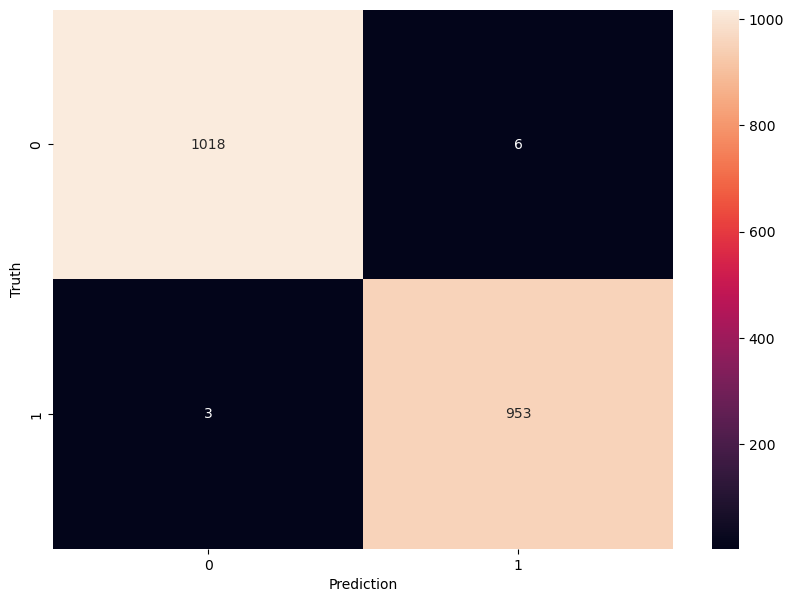

In [33]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')